# GSMM mixture modelling with real data

This notebook contains the following processing blocks:
- Gaussian mixture model
- Complex hierarchical gaussian filter
- Complex to real conversion
- Probabilistic Fourier transform
- Observation noise

## Import packages and functions

In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter
using PyPlot
using GaussianMixtures
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


In [2]:
include("../extensions/ComplexNormal.jl")
include("../extensions/ComplexHGF.jl")
include("../extensions/ComplexToReal.jl")

include("../functions/auxiliary/workflow.jl") 
include("../functions/auxiliary/fourier.jl") 
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/preprocessing.jl") 
;

## Parameters

In [3]:
# data generation parameters
sound_file = "../data/woman.wav"      # specify sound location
fs = 8000                             # specify desired sampling frequency
normalization_method = "max"          # specify normalization method
nr_freqs = 24                         # number of frequencies (excluding DC and fs/2)
nr_clusters = 10                      # number of clusters (needs to be larger than 2 (ForneyLab issue))
bufsize = 2*(nr_freqs+1)              # number of samples in the buffer
stepsize = bufsize                    # step size inbetween buffers
stepsizeT = bufsize
duration_train = 3                    # duration of training data in seconds
duration_test = 5                     # duration of training data in seconds
nr_samples_train = Int((fs*duration_train-bufsize)/stepsizeT) +1        # number of training samples
nr_samples_test = Int(fs/bufsize)*duration_test
Σ_meas = 1e-10*Ic(bufsize)            # covariance matrix of measurement noise (over time in this case)
Σ_noise = 1e-2
;

## Load and process signals

In [4]:
# load speech data
x_speech, fs_speech = wavread(sound_file, format="native")
fs_speech = Int(fs_speech)
duration_max = maximum([duration_train, duration_test])
x_speech = convert(Array{Float64,1}, squeeze(x_speech[:,1]))[1:duration_max*fs_speech]

# pre-process signals
y_speech = preprocess(x_speech, fs_speech, fs_desired=fs)[1:fs*duration_max]
y_speech_true = preprocess(x_speech, fs_speech, fs_desired=fs)
y_speech_n = y_speech_true + sqrt(Σ_noise)*randn(size(y_speech_true))

# warp signal and take fft
f_speech = FFTovertime(y_speech, bufsize, bufsize-stepsizeT, hanningwindow)
f_speech_n = FFTovertime(y_speech_n, bufsize, bufsize-stepsize, hanningwindow)

# reduce fft 
fab_speech =  hcat(real.(f_speech[:,1]), 2*real.(f_speech[:,2:nr_freqs+1]), real.(f_speech[:,nr_freqs+2]), -real.(f_speech[:,1]), -2*imag.(f_speech[:,2:nr_freqs+1]), imag.(f_speech[:,nr_freqs+2]))
fab_speech_n =  hcat(real.(f_speech_n[:,1]), 2*real.(f_speech_n[:,2:nr_freqs+1]), real.(f_speech_n[:,nr_freqs+2]), -real.(f_speech_n[:,1]), -2*imag.(f_speech_n[:,2:nr_freqs+1]), imag.(f_speech_n[:,nr_freqs+2]))

# determine corresponding fft frequencies 
fi = abs.(FFTW.fftfreq(bufsize)[1:nr_freqs+2]*fs)[2:end-1]

# get the log abs values
z_speech = log.(abs2.(fab_speech[:,1:nr_freqs+2]) + abs2.(fab_speech[:,nr_freqs+3:end]))
z_speech_n = log.(abs2.(fab_speech_n[:,1:nr_freqs+2]) + abs2.(fab_speech_n[:,nr_freqs+3:end]))

# create time axis
t = collect(0:length(y_speech_n)-1)/fs

# create audioplayers for signals
audioplayers(y_speech, y_speech_n, fs=fs)
;

<source src="data:audio/wav;base64,UklGRjxxAgBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQBxAgALM0K8iDVHPRCz2jzCW8q618nAu1MnXD3PUY67YH2FPHpImTuNYtQ84gGxvAS+dzutUpa88lEzvLx99jsR5148Y34yPOWwSr04PiM99KY+PU/da7vWz1q8KQAEPUqZkD3JH3Y7SzibvL/4wzy7RdY8wlBJuoZRtL2aOTA8d+yCPJZ0uzwZVx69ByxjvFhMoz2Qi6C8TwJAOqcTSLzcgDI9kWPePKo+yrwafCq6Ik8sPO27+Ds9DEM8gOfnuxaJ7rvdcO48gTwMPCULljy+F3+8JxoaOyAVsjp5Lq48NLOpPKT1i7tm4HU8tzQFusyuLbvbE548rOvEPEVr+rsK3FU8l0glO0tcTrynFuu8b9JPPcBHljvay5w7HfFbvcjRaz2Pu6g8zefxOsAGjLw4xPM81EQRPXDC7rw9h9c8AO8SPfDGvbpN7Ry9ORSZPBZtSD1KSK48Oo8dvLMcFz1erEA9r/EXPBx31rtVZrU8nVAiPOOc8LtPoFK7vrGUPHy7qDxG1kM8GA1Ou7D0aj2cOg49bL+xO1udlzzNOBE9X+qqPI/qLLz4niY8RgllPFxAdrxI5ei6cZDvu4kXSTzJo+08DSvVu5bBmDxMyAo934ocPdiCKL0zaG67c6mPPFivybvuNQ483y19vHm9K7zeDk48kPAZPF1J7zxwutO7xAzMPAryhzvivay6MIDNPMF3hDwEaEE9dW+nvFz4R7uOcv27/R4RPXPi1rtI3Oy8PoE5vLsjHbwxgxA9l4lxu4OKPb08fhK6h7AEPS7dqzxmZv27a3gEvdv0gD26Iu48l7GcvGr/Tr0EW3888EpfPCaKSDqtLsC8L7aFPEk+6TwRVCw7vM2mvOogDryVzEY81w1kvAscnryd/4i8ivNBOxks6bzHL8i89lnlvLh857unv8K8QahZPCeWAr3HbOA4nsY1u/sg37wK/Uu8K77vumlUOTz0wjO9oRUkvO7GHrzr3IE8ot1/vKgGRrwAZLE8qjkKO64lsbs2pN68W7IFvOIRTrt6fDQ8j8U1uz1n6DwlMb+8Od/IvD5aH7x408s8R9kyvJvKWb1gVrg8yLYnPcsez7wgbF69YWGovGd9KD1wEP08NzOGvZYrmbyKAUs9pqVVPYXKtb3pE9S8ngx1PHVHfT0+t/C7YqMLvZYNBL1aSSY96cmCPCeMs7yybhy9pm4AO9ooBj0mpiK8LvY/vY+3lDuulac8YSfSvLd74rzaYeG8ytKvPH+kWTzbEgW8qR6uvEoDpLv6hNg88c0bPHogEL3BQyq82HB5vD2m8DuTjC2933U0uxbalLxvAMW6pcwdPWSByrugYQq89tWruxDWODzRP1k7lTepOkm1krxv9qy7eGFBvCXjlbxZsCO9hO+ZPK8dybxaBS68HdsJvDn2zDzQ0wu7eX29vKohwrwMIJy8AAiuPC8qmbvKJQ+91Gkova6s7zqAawK9EBZFvVBM4LzqSL08k+igvBjpaju9o8U7i9GKPHs3Zr3eSR27dFAWPZzUJ7zXRoS9CFkRvY3xgjzSt928fD2DvXAg3LzwGh+8Z064PKh55bwq8qq7g+KhvIT3TrpLliI8+PArvdNcszt/OoU6YhWIPDODib1I5rI8zcpDPfc9Kr3lKAO9APeMPJNVfj0lZhK954oAvZZgrbszP6w7ts4xvd5FsDuHYaC8BlQRPZy4Ab0Dl/i3u+g7O2wKBzzYLhs92gJ1vULl2rwrlmU8D+pUPVHrEL12UNC8NnP/PKSUmj39yyM89jUVvfxWMLtl2zo9PwYZvMPs+bvRTyw8++jePIHEczy0vTe9gpL7PAT+SD3aR168YLQXva2K57xJC209LirCvCreh7xvGrC86R6qPDf4srr9Ook8JrjzO5Ac1Dxq8yO8p9WUtx9DkjvL0MG8DDXYPIWB7Dyx7VU8p3tNvUVzOTzIAkE9LcreO6RdiL1Ou4U85N1aPcQueTt9fWe9UPU5vENQZT0BtVE9Wg+FOcPDzrxgq0E9UaVnPcIBe7yUyfW7BvhOu3FE9jtyfEc8vojfvDdFTjxYecY8JXh2vG4puTyZnc27jEFEPW1FxTs09C+81Q2gOtRrLDx6cxQ9c1WTvAzchzyghw09GOY2PLOArbymN807Pl0tPWY1ZrxTdwS9CTmQPLVfojtC8AW9sTg3vHbqRT1tH4M8dLe3u23mdDxhYak8etc6Pdk5xTxGsVU8ddZ1uxu4n7wa7Ry7zoD3OWW4y7sZW628ouTku0Utfjy5l7M7pItjvNTuOzyGRAQ8sY+LPLttazxR+nU8ZOSpPEoiNjzhy5o8S2UJPEgbjz2P9ky82eUqvHXnzbtds+U7sOuovKAvVLwqNIM83CLOPFjL7Du62A68X04bu5dArzzsoOQ8ZiUEvELmy7xTLtm80lJDPaYuVbz1VDS9b/wXvaX0jDhwXsg8LR8VvB3ynLvnQg294T7NPNFGjDvPa1q9a9XFvOqhSbwi1qE8j6fePCaOz7urEIe869koPDe60Dzj28c86U0+vGJXurzuLas8OQwOPenyDr3XuFG9qR/iO9TBdjsc4QI8hBPCPOHKiTvAVFo918SUO1gM5jswc8U8kO+jPDMvejze5dC8evkvPIb+ODwvloc7/jVsvTr0Ej3f7So9+V3mvJKIXb0wvvA8NqdHPYbIlrzMiFm94eAIPacx4zw8/AY92Qx5vBC5KTuztqE6BEWBPB6hl7zMVxu9pAODvNa4AzxjZua8jTpSvb3+G7yGV7s7a6iaPN5bH70S6yK8uq3UPICn/jzIw1S9ZOgTvH5MtrveAJM8fA0jvXSLI73+31e70IIOvO0Wpbyo8WW8SnyEPLR9mLw6KhI8ycCXPAmQ3zu9ES28vYt2Oo4gQbyo4jQ85DiqO2BYsLt/0M68JLGDu0383TzptZW82VuEOyv7LDvIwZk7i4OavMU9aTyeCvK8gLfZvODvozz8Mp48R550PHvVkL2PBQE9aMBMPMqjkrqQT3q8uIeUvJLmQzydvf08/nFOPJ1qJTztylO8IOPnO8WEVT1zQQs99KY1O0YliLySkVe8+/5CPWRjJTy46rC86bW+vFXF0DxEZh09Jlu6vLzn6LyvH1889l3sPGh5ejsXm3O8DoZdu4R3VjxFR3q8bJHXvEzHqrxTGCc9MAIlPPpt3rtapwm82HcDPW8t0zwnBW28m/qCvBkZfrzvsvw88xeQvCgqdrxsEa27Fb7bu/w0vrwtFky8rXjaOzpljLsUAHG84FhaOxcEmLuaD6W7pdKXvJAemjxs1fE63bhdvLD+47tC2N87svDCOyOejLz/eLy7OyIFuiLCY7zJKGc8/36uvHlXkjlZpr+6uJ0ivI34bLzaiYy62l68PIAMnrzb5C69W6KsPOJaIzyVs3M6fyv7vGLQH7zders7+venvI+uLb2IFa+8uVWVO0z5HLzCHxe8VesFvbWoEbs/vvs8mgt1vA+/Gb3I6BW8HZDwPAsVnTvOkvS8DR/LvNdOyzssoPG7Ak9XvMTpLry8NI68U3StPEWxb7tfw/s8AfWOvMTXATyrkPw6kivFvA+lRL2RsJQ88MpAPeX+MrtavUw81vsDvSjeizzBEda78ttJvNDct7z7w9g8WLLhPIOMwztSEUS8lys+vLwqPzpB1+i8Rk4DvcMnkTji57O8TT0EvYpr3LvHvCk6QD+RvJlNJb1phVe6HdxmvPzIlTsXap+8O+qrOsHtGTxNQ6A7F5Otuyj3ObxTp9Y8u7gfvEyzH73HRM+8jyypPJhPkrxMBEO8LViIu7YACz1Zem06m70xPDZsjbv8jZm7zhSkPM39oDsIHCo8PEMcvclm9jxM5UM4HLXzO5SY/rygk/U7DyWZPHnbhjyWL

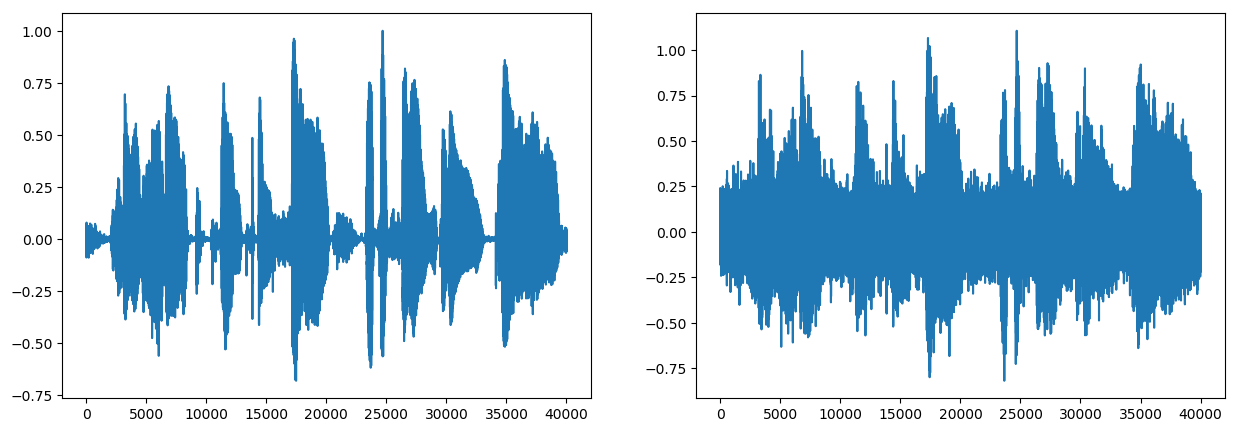

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000612A3780>

In [5]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech_true)
ax[2].plot(y_speech_n)

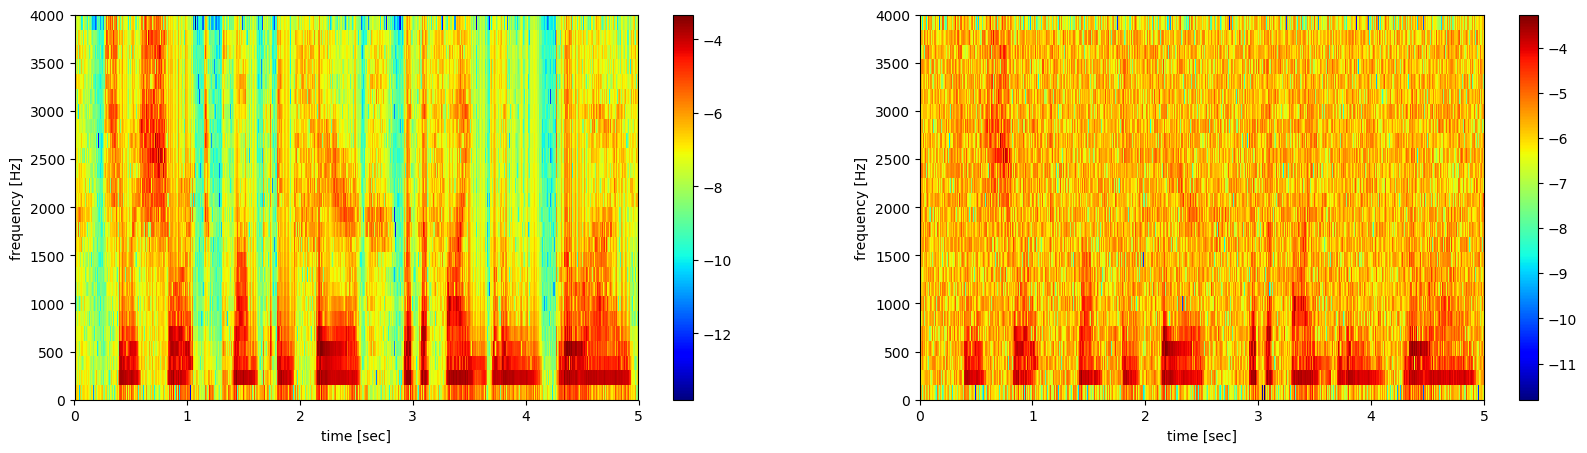

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5))
plot_spectrogram(spectrogram(y_speech_true, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[1], colorbar=true)
#ax[1].get_images()[1].set_clim(-13, -3)
plot_spectrogram(spectrogram(y_speech_n, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[2], colorbar=true)
;

## Train GSMM through K-means and EM

In [7]:
# perform clustering (ignore DC and fs/2)
g = GMM(nr_clusters, z_speech[1:nr_samples_train,2:end-1], nIter=50, nInit=100, kind=:diag)
em!(g, z_speech[1:nr_samples_train,2:end-1])
;

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.995606e+04
      1       3.068561e+04      -1.927044e+04 |       10
      2       2.939774e+04      -1.287871e+03 |        9
      3       2.824482e+04      -1.152927e+03 |        8
      4       2.781501e+04      -4.298062e+02 |        5
      5       2.758048e+04      -2.345243e+02 |        5
      6       2.747892e+04      -1.015695e+02 |        7
      7       2.738717e+04      -9.174298e+01 |        4
      8       2.735265e+04      -3.452125e+01 |        5
      9       2.732472e+04      -2.793225e+01 |        4
     10       2.726387e+04      -6.084672e+01 |        3
     11       2.721420e+04      -4.967607e+01 |        3
     12       2.720083e+04      -1.336928e+01 |        2
     13       2.719748e+04      -3.346574e+00 |        0
     14       2.719748e+04       0.000000e+00 |        0

┌ Info: Initializing GMM, 10 Gaussians diag covariance 24 dimensions using 480 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:78



K-means converged with 14 iterations (objv = 27197.480129501673)


┌ Info: K-means with 480 data points using 14 iterations
│ 1.9 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:139


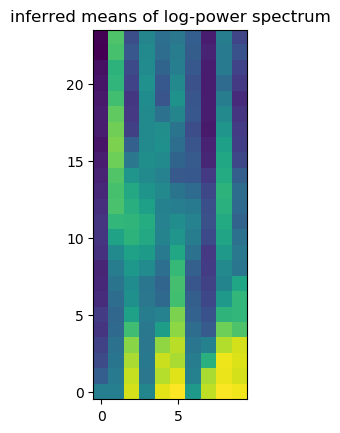

In [8]:
plt.imshow(g.μ', origin="lower")
plt.title("inferred means of log-power spectrum");

## Train GSMM through variational message passing on a factor graph

### Step 1: Build factor graph

In [9]:
# create factor graph
fg = FactorGraph()

# create distionary for variables
vars = Dict()

# specify distribution over the selection variables
@RV vars[:π] ~ ForneyLab.Dirichlet(placeholder(:α_π, dims=(nr_clusters,)))

# create mixture components
for k = 1:nr_clusters
    
    # specify distribution over precision matrix
    @RV vars[pad(:w,k)] ~ Wishart(placeholder(pad(:V_w,k), dims=(nr_freqs,nr_freqs)), placeholder(pad(:nu_w,k)))
    
    # specify distribution over mean
    @RV vars[pad(:m,k)] ~ GaussianMeanPrecision(placeholder(pad(:μ_m,k), dims=(nr_freqs,)), vars[pad(:w,k)])
    
end

# specify distribution over selection variable
@RV vars[:z] ~ Categorical(vars[:π])

# create gaussian mixture model
@RV vars[:ξ] ~ GaussianMixture(vars[:z], expand([[vars[pad(:m,ki)], vars[pad(:w,ki)]] for ki=1:nr_clusters])...)

# log-power to complex fourier coefficients transform
@RV vars[:Xc] ~ ComplexHGF(vars[:ξ])

# complex fourier coefficients to real and imaginary parts concatenated
@RV vars[:Xr] ~ ComplexToReal(vars[:Xc])

# probabilistic Fourier transform
@RV vars[:x] = placeholder(:C, dims=(bufsize, 2*(nr_freqs)))*vars[:Xr]

# observation model 
@RV vars[:y] ~ GaussianMeanVariance(vars[:x], Σ_meas)

# observation
placeholder(vars[:y], :y, dims=(bufsize,))

# draw graph
ForneyLab.draw(fg)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 1591835743629373762 -->
 1591835743629373762 
 
 placeholder_C 
 
<!-- 45288715852712081 -->
 45288715852712081 
 
 𝒩 
 gaussianmeanprecision_4 
 
<!-- 8151754621638144290 -->
 8151754621638144290 
 
 placeholder_μ_m_04 
 
<!-- 45288715852712081--8151754621638144290 -->
 45288715852712081--8151754621638144290 
 
 μ_m_04 
 1 out 
 2 m 
 
<!-- 4147631828664070911 -->
 4147631828664070911 
 
 W 
 wishart_10 
 
<!-- 1776130181075300167 -->
 1776130181075300167 
 
 placeholder_nu_w_10 
 
<!-- 4147631828664070911--1776130181075300167 -->
 4147631828664070911--1776130181075300167 
 
 nu_w_10 
 1 out 
 3 nu 
 
<!-- 8789951425276034611 -->
 8789951425276034611 
 
 placeholder_V_w_10 
 
<!-- 4147631828664070911--8789951425276034611 -->
 4147631828664070911--8789951425276034611 
 
 V_w_10 
 1 out 
 2 v 
 
<!-- 14006789692575015945 -->
 14006789692575015945 
 
 = 
 equ_vars_w_07_1 
 
<!-- 16476212491679840356 -->
 16476212491679840356 
 
 GM 
 gaussianmixture_1 
 
<!-- 14006789692575015945--16476212491679840356 -->
 14006789692575015945--16476212491679840356 
 
 vars_w_07 
 16 w7 
 3 3 
 
<!-- 11522278674343562453 -->
 11522278674343562453 
 
 W 
 wishart_7 
 
<!-- 14006789692575015945--11522278674343562453 -->
 14006789692575015945--11522278674343562453 
 
 vars_w_07 
 1 out 
 1 1 
 
<!-- 14771617704548652388 -->
 14771617704548652388 
 
 𝒩 
 gaussianmeanprecision_7 
 
<!-- 14006789692575015945--14771617704548652388 -->
 14006789692575015945--14771617704548652388 
 
 vars_w_07 
 3 w 
 2 2 
 
<!-- 14195732006107027998 -->
 14195732006107027998 
 
 placeholder_nu_w_02 
 
<!-- 10226709178393217874 -->
 10226709178393217874 
 
 𝒩 
 gaussianmeanprecision_9 
 
<!-- 10336313706105735421 -->
 10336313706105735421 
 
 placeholder_μ_m_09 
 
<!-- 10226709178393217874--10336313706105735421 -->
 10226709178393217874--10336313706105735421 
 
 μ_m_09 
 1 out 
 2 m 
 
<!-- 7723217011722980123 -->
 7723217011722980123 
 
 placeholder_nu_w_05 
 
<!-- 7256930236292735563 -->
 7256930236292735563 
 
 placeholder_nu_w_09 
 
<!-- 17712055483036127514 -->
 17712055483036127514 
 
 = 
 equ_vars_w_02_1 
 
<!-- 17712055483036127514--16476212491679840356 -->
 17712055483036127514--16476212491679840356 
 
 vars_w_02 
 6 w2 
 3 3 
 
<!-- 13217485316775406300 -->
 13217485316775406300 
 
 W 
 wishart_2 
 
<!-- 17712055483036127514--13217485316775406300 -->
 17712055483036127514--13217485316775406300 
 
 vars_w_02 
 1 out 
 1 1 
 
<!-- 9563871172407215483 -->
 9563871172407215483 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 17712055483036127514--9563871172407215483 -->
 17712055483036127514--9563871172407215483 
 
 vars_w_02 
 3 w 
 2 2 
 
<!-- 13884514329390519986 -->
 13884514329390519986 
 
 = 
 equ_vars_w_06_1 
 
<!-- 16914275717270962872 -->
 16914275717270962872 
 
 W 
 wishart_6 
 
<!-- 13884514329390519986--16914275717270962872 -->
 13884514329390519986--16914275717270962872 
 
 vars_w_06 
 1 out 
 1 1 
 
<!-- 13884514329390519986--16476212491679840356 -->
 13884514329390519986--16476212491679840356 
 
 vars_w_06 
 14 w6 
 3 3 
 
<!-- 4741611795793798275 -->
 4741611795793798275 
 
 𝒩 
 gaussianmeanprecision_6 
 
<!-- 13884514329390519986--4741611795793798275 -->
 13884514329390519986--4741611795793798275 
 
 vars_w_06 
 3 w 
 2 2 
 
<!-- 10408732736709326444 -->
 10408732736709326444 
 
 placeholder_nu_w_06 
 
<!-- 16914275717270962872--10408732736709326444 -->
 16914275717270962872--10408732736709326444 
 
 nu_w_06 
 1 out 
 3 nu 
 
<!-- 2702137742697125712 -->
 270213774269712571

### Step 2: Generate inference algorithm

In [10]:
# specify ids for the posterior factorization
q_ids = vcat(:Π,
              expand([[pad(:M,k), pad(:W,k)] for k=1:nr_clusters]),
              :Z, :Xc, :Ξ)

# specify posterior factorization
q = PosteriorFactorization(vars[:π], 
                           expand([[vars[pad(:m,k)], vars[pad(:w,k)]] for k=1:nr_clusters])...,
                           vars[:z], vars[:Xc], vars[:ξ],
                           ids=q_ids)

# generate the inference algorithm
algo = variationalAlgorithm(q)

# Generate source code
source_code = algorithmSourceCode(algo)

# Load algorithm
eval(Meta.parse(source_code))
;

### Step 3: create data and marginals dictionary

In [11]:
y_samples = [y_speech[(k-1)*stepsizeT+1:(k-1)*stepsizeT+bufsize].*hanningwindow(bufsize) for k = 1:nr_samples_train];
#y_samples_n = [y_speech_n[(k-1)*bufsize+1:k*bufsize] for k = 1:nr_samples_train];
t_samples = [t[(k-1)*stepsizeT+1:(k-1)*stepsizeT+bufsize] for k = 1:nr_samples_train];
;

### Step 4: Perform inference

In [12]:
# set number of iterations
nr_its = 20

# placeholders for priors
μ_m_min = Array{Array{Float64,1},1}(undef, nr_clusters)
nu_w_min = Array{Float64,1}(undef, nr_clusters)
V_w_min = Array{Array{Float64,2},1}(undef, nr_clusters)

# set priors (and current values later on)
α_π_min = ones(nr_clusters)
for k = 1:nr_clusters
    μ_m_min[k] = g.μ[k,:]
    nu_w_min[k] = nr_freqs
    V_w_min[k] = diagm(1 ./g.Σ[k,:]) / nr_freqs
end

# memory placeholders
z_mem = Array{Int64,1}(undef, nr_samples_train)

# create progress bar
p = Progress(nr_samples_train)

# perform iterations
for i = 1:nr_samples_train
    
    # create data dictionary
    data = Dict()
    data[:y] = y_samples[i]
    data[:α_π] = α_π_min
    for k = 1:nr_clusters
        data[pad(:μ_m,k)] = μ_m_min[k]
        data[pad(:nu_w,k)] = nu_w_min[k]
        data[pad(:V_w,k)] = V_w_min[k]
    end
    data[:C] = 1/bufsize*hcat(cos.(2*pi*fi*t_samples[i]')', sin.(2*pi*fi*t_samples[i]')')
    
    # create marginals dictionary
    marginals = Dict()
    marginals[:vars_π] = ProbabilityDistribution(ForneyLab.Dirichlet, a=α_π_min)
    for k = 1:nr_clusters
        marginals[pad(:vars_m,k)] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=data[pad(:μ_m,k)], w=data[pad(:V_w,k)]*data[pad(:nu_w,k)])
        marginals[pad(:vars_w,k)] = ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=data[pad(:V_w,k)], nu=data[pad(:nu_w,k)])
    end
    marginals[:vars_z] = vague(Categorical)
    marginals[:vars_Xc] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=1e10*Ic(nr_freqs).+0.0im, C=mat(0.0+0.0im))
    marginals[:vars_ξ] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=z_speech[i,2:end-1], v=0.1*Ic(nr_freqs))
    
    for _ = 1:nr_its
        # perform updates
        stepXc!(data, marginals)
        stepΞ!(data, marginals)
        stepZ!(data, marginals)
        stepΠ!(data, marginals) 
        for k = 1:nr_clusters
            getfield(Main, Symbol("stepM_"*string(k,pad=2)*"!"))(data, marginals)
            getfield(Main, Symbol("stepW_"*string(k,pad=2)*"!"))(data, marginals)
        end
    end
    
    # extract parameters and update beliefs
    α_π_min = marginals[:vars_π].params[:a]
    for k = 1:nr_clusters
        μ_m_min[k] = ForneyLab.unsafeMean(marginals[pad(:vars_m,k)])
        nu_w_min[k] = marginals[pad(:vars_w,k)].params[:nu]
        V_w_min[k] = marginals[pad(:vars_w,k)].params[:v]
    end
    z_mem[i] = findmax(marginals[:vars_z].params[:p])[2]
    
    # update progress bar
    next!(p)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:56


### Step 5: Analyze results

In [13]:
# get inferred cluster assignments and print confusion matrix
z_train_em = [findmax(llpg(g, z_speech[1:nr_samples_train,2:end-1])[k,:])[2] for k = 1:g.nx];
z_train_inf = z_mem

# get clusters with zero assignments
remaining_clusters = unique(z_train_inf)
rm_clusters = length(remaining_clusters)

# plot confusion matrix
confusionmatrix(nr_clusters, z_train_em .- minimum(z_train_em) .+ 1, z_train_inf .- minimum(z_train_inf) .+ 1)

10×10 Array{Int64,2}:
 6  0   0  16   0  0  49  7  0  0
 0  2   0   0   0  0  53  0  0  0
 0  0  15   0   0  0  15  0  0  0
 0  0   0  11   0  0  73  0  0  0
 0  0   0   0  22  0  15  0  0  0
 0  0   0   0   2  0  22  0  0  0
 0  0   1  17   1  0  50  1  0  0
 0  0   0   0   1  0  32  1  0  0
 0  0   0   0  17  0  24  0  0  0
 0  0  10   0   3  0   6  0  0  8

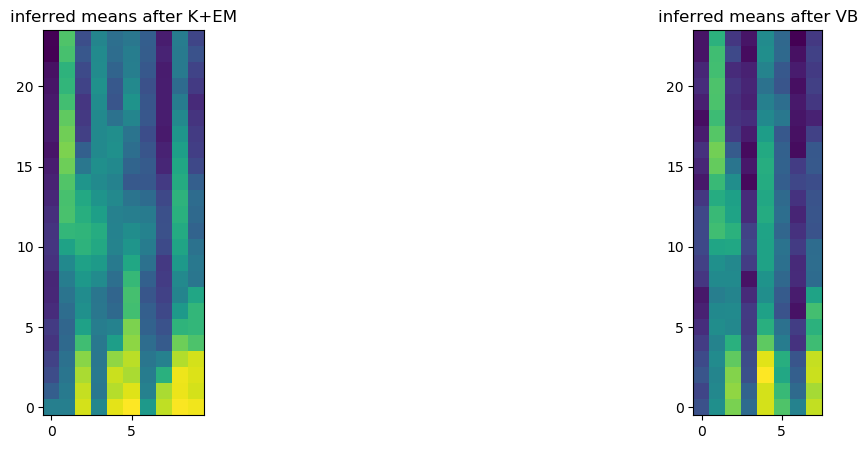

PyObject Text(0.5, 1.0, 'inferred means after VB')

In [14]:
# get new means and variances of remaining clustersand show results
μ_trained = []
V_trained = []
nu_trained = []
α_π_trained = []
for k = 1:nr_clusters
    if k in remaining_clusters
        push!(μ_trained, μ_m_min[k])
        push!(V_trained, V_w_min[k])
        push!(nu_trained, nu_w_min[k])
        push!(α_π_trained, α_π_min[k])
    end
end

# plot new and previous means
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].imshow(g.μ', origin="lower")
ax[1].set_title("inferred means after K+EM")
ax[2].imshow(hcat(μ_trained...), origin="lower")
ax[2].set_title("inferred means after VB")


## Perform speech enhancement

### Step 1: build factor graph

In [15]:
# create factor graph
fg = FactorGraph()

# create distionary for variables
vars_e = Dict()

# specify distribution over the selection variables
@RV vars_e[:π] ~ ForneyLab.Dirichlet(placeholder(:α_π, dims=(rm_clusters,)))

# create mixture components
for k = 1:rm_clusters
    
    # specify distribution over precision matrix
    @RV vars_e[pad(:w,k)] ~ Wishart(placeholder(pad(:V_w,k), dims=(nr_freqs,nr_freqs)), placeholder(pad(:nu_w,k)))
    
    # specify distribution over mean
    @RV vars_e[pad(:m,k)] ~ GaussianMeanPrecision(placeholder(pad(:μ_m,k), dims=(nr_freqs,)), vars_e[pad(:w,k)])
    
end

# specify distribution over selection variable
@RV vars_e[:z] ~ Categorical(vars_e[:π])

# create gaussian mixture model
@RV vars_e[:ξ] ~ GaussianMixture(vars_e[:z], expand([[vars_e[pad(:m,ki)], vars_e[pad(:w,ki)]] for ki=1:rm_clusters])...)

# log-power to complex fourier coefficients transform
@RV vars_e[:Xc] ~ ComplexHGF(vars_e[:ξ])

# complex fourier coefficients to real and imaginary parts concatenated
@RV vars_e[:Xr] ~ ComplexToReal(vars_e[:Xc])

# probabilistic Fourier transform
@RV vars_e[:x] = placeholder(:C, dims=(bufsize, 2*(nr_freqs)))*vars_e[:Xr]

# observation model 
@RV vars_e[:y] ~ GaussianMeanVariance(vars_e[:x], Σ_noise*Ic(bufsize))

# observation
placeholder(vars_e[:y], :y, dims=(bufsize,))
   
# draw graph
ForneyLab.draw(fg)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 6016411408524662713 -->
 6016411408524662713 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 6364582896136458288 -->
 6364582896136458288 
 
 placeholder_μ_m_03 
 
<!-- 6016411408524662713--6364582896136458288 -->
 6016411408524662713--6364582896136458288 
 
 μ_m_03 
 1 out 
 2 m 
 
<!-- 17852614551975768719 -->
 17852614551975768719 
 
 placeholder_μ_m_06 
 
<!-- 3602630890124588518 -->
 3602630890124588518 
 
 placeholder_nu_w_08 
 
<!-- 3955163227578995288 -->
 3955163227578995288 
 
 placeholder_μ_m_07 
 
<!-- 4291183717741698734 -->
 4291183717741698734 
 
 ComplexHGF 
 complexhgf_1 
 
<!-- 16933072447160832483 -->
 16933072447160832483 
 
 GM 
 gaussianmixture_1 
 
<!-- 4291183717741698734--16933072447160832483 -->
 4291183717741698734--16933072447160832483 
 
 vars_e_ξ 
 1 out 
 2 ξ 
 
<!-- 8077846244525970912 -->
 8077846244525970912 
 
 = 
 equ_vars_e_w_04_1 
 
<!-- 8077846244525970912--16933072447160832483 -->
 8077846244525970912--16933072447160832483 
 
 vars_e_w_04 
 10 w4 
 3 3 
 
<!-- 3297714359626799930 -->
 3297714359626799930 
 
 W 
 wishart_4 
 
<!-- 8077846244525970912--3297714359626799930 -->
 8077846244525970912--3297714359626799930 
 
 vars_e_w_04 
 1 out 
 1 1 
 
<!-- 11036225846188222957 -->
 11036225846188222957 
 
 𝒩 
 gaussianmeanprecision_4 
 
<!-- 8077846244525970912--11036225846188222957 -->
 8077846244525970912--11036225846188222957 
 
 vars_e_w_04 
 3 w 
 2 2 
 
<!-- 2525996031462931268 -->
 2525996031462931268 
 
 Dir 
 dirichlet_1 
 
<!-- 8022707959166274855 -->
 8022707959166274855 
 
 placeholder_α_π 
 
<!-- 2525996031462931268--8022707959166274855 -->
 2525996031462931268--8022707959166274855 
 
 α_π 
 1 out 
 2 a 
 
<!-- 8716848622966053374 -->
 8716848622966053374 
 
 × 
 multiplication_1 
 
<!-- 7436356281268814850 -->
 7436356281268814850 
 
 placeholder_C 
 
<!-- 8716848622966053374--7436356281268814850 -->
 8716848622966053374--7436356281268814850 
 
 C 
 1 out 
 3 a 
 
<!-- 1350202139574391987 -->
 1350202139574391987 
 
 ComplexToReal 
 complextoreal_1 
 
<!-- 8716848622966053374--1350202139574391987 -->
 8716848622966053374--1350202139574391987 
 
 vars_e_Xr 
 1 rx 
 2 in1 
 
<!-- 5388485939721000719 -->
 5388485939721000719 
 
 Cat 
 categorical_1 
 
<!-- 5388485939721000719--2525996031462931268 -->
 5388485939721000719--2525996031462931268 
 
 vars_e_π 
 1 out 
 2 p 
 
<!-- 5394243255444079346 -->
 5394243255444079346 
 
 placeholder_μ_m_04 
 
<!-- 16933072447160832483--6016411408524662713 -->
 16933072447160832483--6016411408524662713 
 
 vars_e_m_03 
 1 out 
 7 m3 
 
<!-- 16933072447160832483--5388485939721000719 -->
 16933072447160832483--5388485939721000719 
 
 vars_e_z 
 1 out 
 2 z 
 
<!-- 14349347253892582100 -->
 14349347253892582100 
 
 𝒩 
 gaussianmeanprecision_7 
 
<!-- 16933072447160832483--14349347253892582100 -->
 16933072447160832483--14349347253892582100 
 
 vars_e_m_07 
 1 out 
 15 m7 
 
<!-- 16933072447160832483--11036225846188222957 -->
 16933072447160832483--11036225846188222957 
 
 vars_e_m_04 
 1 out 
 9 m4 
 
<!-- 9683009043613465795 -->
 9683009043613465795 
 
 𝒩 
 gaussianmeanprecision_5 
 
<!-- 16933072447160832483--9683009043613465795 -->
 16933072447160832483--9683009043613465795 
 
 vars_e_m_05 
 1 out 
 11 m5 
 
<!-- 2078512032229997997 -->
 2078512032229997997 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 16933072447160832483--2078512032229997997 -->
 16933072447160832483--2078512032229997997 
 
 vars_e_m_02 
 1 out 
 5 m2 
 
<!-- 16025380178758862785 -->
 16025380178758862785 
 


### Step 2: Generate inference algorithm

In [16]:
# specify ids for the posterior factorization
q_ids = vcat(:Π,
              expand([[pad(:M,k), pad(:W,k)] for k=1:rm_clusters]),
              :Z, :Xc, :Ξ)

# specify posterior factorization
q = PosteriorFactorization(vars_e[:π], 
                           expand([[vars_e[pad(:m,k)], vars_e[pad(:w,k)]] for k=1:rm_clusters])...,
                           vars_e[:z], vars_e[:Xc], vars_e[:ξ], ids=q_ids)

# generate the inference algorithm
algo = variationalAlgorithm(q)

# Generate source code
source_code = algorithmSourceCode(algo)

# Load algorithm
eval(Meta.parse(source_code))
;

### Step 3: inference

In [17]:
# prevent posdef errors (Marco his comment on ForneyLab issue #86)
function safeChol(A::Hermitian)
    # `safeChol(A)` is a 'safe' version of `chol(A)` in the sense
    # that it adds jitter to the diagonal of `A` and tries again if
    # `chol` raised a `PosDefException`.
    # Matrix `A` can be non-positive-definite in practice even though it
    # shouldn't be in theory due to finite floating point precision.
    # If adding jitter does not help, `PosDefException` will still be raised.
    L = similar(A)
    try
        L = cholesky(A)
        catch #Base.LinAlg.PosDefException
        # Add jitter to diagonal to break linear dependence among rows/columns.
        # The additive noise is input-dependent to make sure that we hit the
        # significant precision of the Float64 values with high probability.
        jitter = Diagonal(1e-13*(rand(size(A,1))) .* diag(A))
        L = cholesky(A + jitter)
    end
end
ForneyLab.unsafeMean(dist::ProbabilityDistribution{Multivariate, GaussianWeightedMeanPrecision}) = inv(safeChol(Hermitian(dist.params[:w])))*dist.params[:xi]
unsafeMean(dist::ProbabilityDistribution{Multivariate, GaussianWeightedMeanPrecision}) = inv(safeChol(Hermitian(dist.params[:w])))*dist.params[:xi]

unsafeMean (generic function with 16 methods)

In [18]:
stepsizeX = Int(bufsize/2)
# load speech data
x_speech, fs_speech = wavread(sound_file, format="native")
fs_speech = Int(fs_speech)
duration_max = maximum([duration_train, duration_test])
x_speech = convert(Array{Float64,1}, squeeze(x_speech[:,1]))[1:duration_max*fs_speech]

# pre-process signals
y_speech = preprocess(x_speech, fs_speech, fs_desired=fs)[1:fs*duration_max]
y_speech_true = preprocess(x_speech, fs_speech, fs_desired=fs)
y_speech_n = y_speech_true + sqrt(Σ_noise)*randn(size(y_speech_true))

# warp signal and take fft
f_speech_n = FFTovertime(y_speech_n, bufsize, bufsize-stepsizeX, hanningwindow)

# reduce fft 
fab_speech_n =  hcat(real.(f_speech_n[:,1]), 2*real.(f_speech_n[:,2:nr_freqs+1]), real.(f_speech_n[:,nr_freqs+2]), -real.(f_speech_n[:,1]), -2*imag.(f_speech_n[:,2:nr_freqs+1]), imag.(f_speech_n[:,nr_freqs+2]))

# determine corresponding fft frequencies 
fi = abs.(FFTW.fftfreq(bufsize)[1:nr_freqs+2]*fs)[2:end-1]

# get the log abs values
z_speech_n = log.(abs2.(fab_speech_n[:,1:nr_freqs+2]) + abs2.(fab_speech_n[:,nr_freqs+3:end]))

# create time axis
t = collect(0:length(y_speech_n)-1)/fs

# create audioplayers for signals
audioplayers(y_speech, y_speech_n, fs=fs)
;

<source src="data:audio/wav;base64,UklGRjxxAgBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQBxAgALM0K8iDVHPRCz2jzCW8q618nAu1MnXD3PUY67YH2FPHpImTuNYtQ84gGxvAS+dzutUpa88lEzvLx99jsR5148Y34yPOWwSr04PiM99KY+PU/da7vWz1q8KQAEPUqZkD3JH3Y7SzibvL/4wzy7RdY8wlBJuoZRtL2aOTA8d+yCPJZ0uzwZVx69ByxjvFhMoz2Qi6C8TwJAOqcTSLzcgDI9kWPePKo+yrwafCq6Ik8sPO27+Ds9DEM8gOfnuxaJ7rvdcO48gTwMPCULljy+F3+8JxoaOyAVsjp5Lq48NLOpPKT1i7tm4HU8tzQFusyuLbvbE548rOvEPEVr+rsK3FU8l0glO0tcTrynFuu8b9JPPcBHljvay5w7HfFbvcjRaz2Pu6g8zefxOsAGjLw4xPM81EQRPXDC7rw9h9c8AO8SPfDGvbpN7Ry9ORSZPBZtSD1KSK48Oo8dvLMcFz1erEA9r/EXPBx31rtVZrU8nVAiPOOc8LtPoFK7vrGUPHy7qDxG1kM8GA1Ou7D0aj2cOg49bL+xO1udlzzNOBE9X+qqPI/qLLz4niY8RgllPFxAdrxI5ei6cZDvu4kXSTzJo+08DSvVu5bBmDxMyAo934ocPdiCKL0zaG67c6mPPFivybvuNQ483y19vHm9K7zeDk48kPAZPF1J7zxwutO7xAzMPAryhzvivay6MIDNPMF3hDwEaEE9dW+nvFz4R7uOcv27/R4RPXPi1rtI3Oy8PoE5vLsjHbwxgxA9l4lxu4OKPb08fhK6h7AEPS7dqzxmZv27a3gEvdv0gD26Iu48l7GcvGr/Tr0EW3888EpfPCaKSDqtLsC8L7aFPEk+6TwRVCw7vM2mvOogDryVzEY81w1kvAscnryd/4i8ivNBOxks6bzHL8i89lnlvLh857unv8K8QahZPCeWAr3HbOA4nsY1u/sg37wK/Uu8K77vumlUOTz0wjO9oRUkvO7GHrzr3IE8ot1/vKgGRrwAZLE8qjkKO64lsbs2pN68W7IFvOIRTrt6fDQ8j8U1uz1n6DwlMb+8Od/IvD5aH7x408s8R9kyvJvKWb1gVrg8yLYnPcsez7wgbF69YWGovGd9KD1wEP08NzOGvZYrmbyKAUs9pqVVPYXKtb3pE9S8ngx1PHVHfT0+t/C7YqMLvZYNBL1aSSY96cmCPCeMs7yybhy9pm4AO9ooBj0mpiK8LvY/vY+3lDuulac8YSfSvLd74rzaYeG8ytKvPH+kWTzbEgW8qR6uvEoDpLv6hNg88c0bPHogEL3BQyq82HB5vD2m8DuTjC2933U0uxbalLxvAMW6pcwdPWSByrugYQq89tWruxDWODzRP1k7lTepOkm1krxv9qy7eGFBvCXjlbxZsCO9hO+ZPK8dybxaBS68HdsJvDn2zDzQ0wu7eX29vKohwrwMIJy8AAiuPC8qmbvKJQ+91Gkova6s7zqAawK9EBZFvVBM4LzqSL08k+igvBjpaju9o8U7i9GKPHs3Zr3eSR27dFAWPZzUJ7zXRoS9CFkRvY3xgjzSt928fD2DvXAg3LzwGh+8Z064PKh55bwq8qq7g+KhvIT3TrpLliI8+PArvdNcszt/OoU6YhWIPDODib1I5rI8zcpDPfc9Kr3lKAO9APeMPJNVfj0lZhK954oAvZZgrbszP6w7ts4xvd5FsDuHYaC8BlQRPZy4Ab0Dl/i3u+g7O2wKBzzYLhs92gJ1vULl2rwrlmU8D+pUPVHrEL12UNC8NnP/PKSUmj39yyM89jUVvfxWMLtl2zo9PwYZvMPs+bvRTyw8++jePIHEczy0vTe9gpL7PAT+SD3aR168YLQXva2K57xJC209LirCvCreh7xvGrC86R6qPDf4srr9Ook8JrjzO5Ac1Dxq8yO8p9WUtx9DkjvL0MG8DDXYPIWB7Dyx7VU8p3tNvUVzOTzIAkE9LcreO6RdiL1Ou4U85N1aPcQueTt9fWe9UPU5vENQZT0BtVE9Wg+FOcPDzrxgq0E9UaVnPcIBe7yUyfW7BvhOu3FE9jtyfEc8vojfvDdFTjxYecY8JXh2vG4puTyZnc27jEFEPW1FxTs09C+81Q2gOtRrLDx6cxQ9c1WTvAzchzyghw09GOY2PLOArbymN807Pl0tPWY1ZrxTdwS9CTmQPLVfojtC8AW9sTg3vHbqRT1tH4M8dLe3u23mdDxhYak8etc6Pdk5xTxGsVU8ddZ1uxu4n7wa7Ry7zoD3OWW4y7sZW628ouTku0Utfjy5l7M7pItjvNTuOzyGRAQ8sY+LPLttazxR+nU8ZOSpPEoiNjzhy5o8S2UJPEgbjz2P9ky82eUqvHXnzbtds+U7sOuovKAvVLwqNIM83CLOPFjL7Du62A68X04bu5dArzzsoOQ8ZiUEvELmy7xTLtm80lJDPaYuVbz1VDS9b/wXvaX0jDhwXsg8LR8VvB3ynLvnQg294T7NPNFGjDvPa1q9a9XFvOqhSbwi1qE8j6fePCaOz7urEIe869koPDe60Dzj28c86U0+vGJXurzuLas8OQwOPenyDr3XuFG9qR/iO9TBdjsc4QI8hBPCPOHKiTvAVFo918SUO1gM5jswc8U8kO+jPDMvejze5dC8evkvPIb+ODwvloc7/jVsvTr0Ej3f7So9+V3mvJKIXb0wvvA8NqdHPYbIlrzMiFm94eAIPacx4zw8/AY92Qx5vBC5KTuztqE6BEWBPB6hl7zMVxu9pAODvNa4AzxjZua8jTpSvb3+G7yGV7s7a6iaPN5bH70S6yK8uq3UPICn/jzIw1S9ZOgTvH5MtrveAJM8fA0jvXSLI73+31e70IIOvO0Wpbyo8WW8SnyEPLR9mLw6KhI8ycCXPAmQ3zu9ES28vYt2Oo4gQbyo4jQ85DiqO2BYsLt/0M68JLGDu0383TzptZW82VuEOyv7LDvIwZk7i4OavMU9aTyeCvK8gLfZvODvozz8Mp48R550PHvVkL2PBQE9aMBMPMqjkrqQT3q8uIeUvJLmQzydvf08/nFOPJ1qJTztylO8IOPnO8WEVT1zQQs99KY1O0YliLySkVe8+/5CPWRjJTy46rC86bW+vFXF0DxEZh09Jlu6vLzn6LyvH1889l3sPGh5ejsXm3O8DoZdu4R3VjxFR3q8bJHXvEzHqrxTGCc9MAIlPPpt3rtapwm82HcDPW8t0zwnBW28m/qCvBkZfrzvsvw88xeQvCgqdrxsEa27Fb7bu/w0vrwtFky8rXjaOzpljLsUAHG84FhaOxcEmLuaD6W7pdKXvJAemjxs1fE63bhdvLD+47tC2N87svDCOyOejLz/eLy7OyIFuiLCY7zJKGc8/36uvHlXkjlZpr+6uJ0ivI34bLzaiYy62l68PIAMnrzb5C69W6KsPOJaIzyVs3M6fyv7vGLQH7zders7+venvI+uLb2IFa+8uVWVO0z5HLzCHxe8VesFvbWoEbs/vvs8mgt1vA+/Gb3I6BW8HZDwPAsVnTvOkvS8DR/LvNdOyzssoPG7Ak9XvMTpLry8NI68U3StPEWxb7tfw/s8AfWOvMTXATyrkPw6kivFvA+lRL2RsJQ88MpAPeX+MrtavUw81vsDvSjeizzBEda78ttJvNDct7z7w9g8WLLhPIOMwztSEUS8lys+vLwqPzpB1+i8Rk4DvcMnkTji57O8TT0EvYpr3LvHvCk6QD+RvJlNJb1phVe6HdxmvPzIlTsXap+8O+qrOsHtGTxNQ6A7F5Otuyj3ObxTp9Y8u7gfvEyzH73HRM+8jyypPJhPkrxMBEO8LViIu7YACz1Zem06m70xPDZsjbv8jZm7zhSkPM39oDsIHCo8PEMcvclm9jxM5UM4HLXzO5SY/rygk/U7DyWZPHnbhjyWL

In [19]:
y_samples = [y_speech[(k-1)*stepsizeX+1:(k-1)*stepsizeX+bufsize].*hanningwindow(bufsize) for k = 1:2*nr_samples_test-1];
y_samples_n = [y_speech_n[(k-1)*stepsizeX+1:(k-1)*stepsizeX+bufsize].*hanningwindow(bufsize) for k = 1:2*nr_samples_test-1];
t_samples = [t[(k-1)*stepsizeX+1:(k-1)*stepsizeX+bufsize] for k = 1:2*nr_samples_test-1];
;

In [20]:
# create placeholders
ξ_inferred = Array{Float64, 2}(undef, 2*nr_samples_test-1, nr_freqs)
x_inferred = Array{Float64, 2}(undef, 2*nr_samples_test-1, bufsize)

# loop through segments
@showprogress for k = 1:2*nr_samples_test-1
    
    # set number of iterations
    nr_its = 10

    # create data dictionary
    data = Dict()

    # specify input data and measurement noise
    data[:y] = y_samples_n[k] .- mean(y_samples_n[k])

    # specify priors over class probabilities
    data[:α_π] = α_π_trained

    # specify priors over clusters
    for ki = 1:rm_clusters
        data[pad(:μ_m,ki)] = μ_trained[ki]
        data[pad(:nu_w,ki)] = nu_trained[ki]
        data[pad(:V_w,ki)] =  V_trained[ki]
    end

    # specify probabilistic fourier matrices
    data[:C] = 1/bufsize*hcat(cos.(2*pi*fi*t_samples[k]')', sin.(2*pi*fi*t_samples[k]')')
    

    # create marginals dictionary
    marginals = Dict()

    # specify marginals over class probabilities
    marginals[:vars_e_π] = ProbabilityDistribution(ForneyLab.Dirichlet, a=α_π_trained)

    # specify marginals over clusters
    for ki = 1:rm_clusters
        marginals[pad(:vars_e_m,ki)] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=data[pad(:μ_m,ki)], w=data[pad(:V_w,ki)]*data[pad(:nu_w,ki)])
        marginals[pad(:vars_e_w,ki)] = ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=data[pad(:V_w,ki)], nu=data[pad(:nu_w,ki)])
    end
    
    # specify marginals over samples
    #marginals[:vars_e_z] = vague(Categorical)
    marginals[:vars_e_z] = ProbabilityDistribution(Categorical, p=α_π_trained/sum(α_π_trained))
    #marginals[:vars_e_z] = ProbabilityDistribution(Categorical, p=exp.(α_π_trained)/sum(exp.(α_π_trained))) # not sure whether best way
    marginals[:vars_e_Xc] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=(1e10)*Ic(nr_freqs).+0.0im, C=mat(0.0+0.0im))
    marginals[:vars_e_ξ] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=z_speech_n[k,2:end-1], v=0.1*Ic(nr_freqs))
                    
    # perform iterations
    for i = 1:nr_its

        # perform updates
        Base.invokelatest(stepXc!, data, marginals)
        Base.invokelatest(stepΞ!, data, marginals)
        Base.invokelatest(stepZ!, data, marginals)
        
    end
    try
        ξ_inferred[k,:] = ForneyLab.unsafeMean(marginals[:vars_e_ξ])
        x_inferred[k,:] = ForneyLab.unsafeMean(marginals[:vars_e_x]) .+ mean(y_samples[k])
    catch
        ξ_inferred[k,:] = zeros(nr_freqs)
        x_inferred[k,:] = zeros(bufsize)
        println("Posdef Exception, k="*string(k))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:16


### Step 4: results

In [21]:
# reshape enhance speech signal
y_enhanced = zeros(size(y_speech_n,1))
for k = 1:size(x_inferred,1)
    y_enhanced[(k-1)*stepsizeX+1:(k-1)*stepsizeX+bufsize] = y_enhanced[(k-1)*stepsizeX+1:(k-1)*stepsizeX+bufsize] + x_inferred[k,:]
end
#y_enhanced = vcat(x_inferred'...)
;

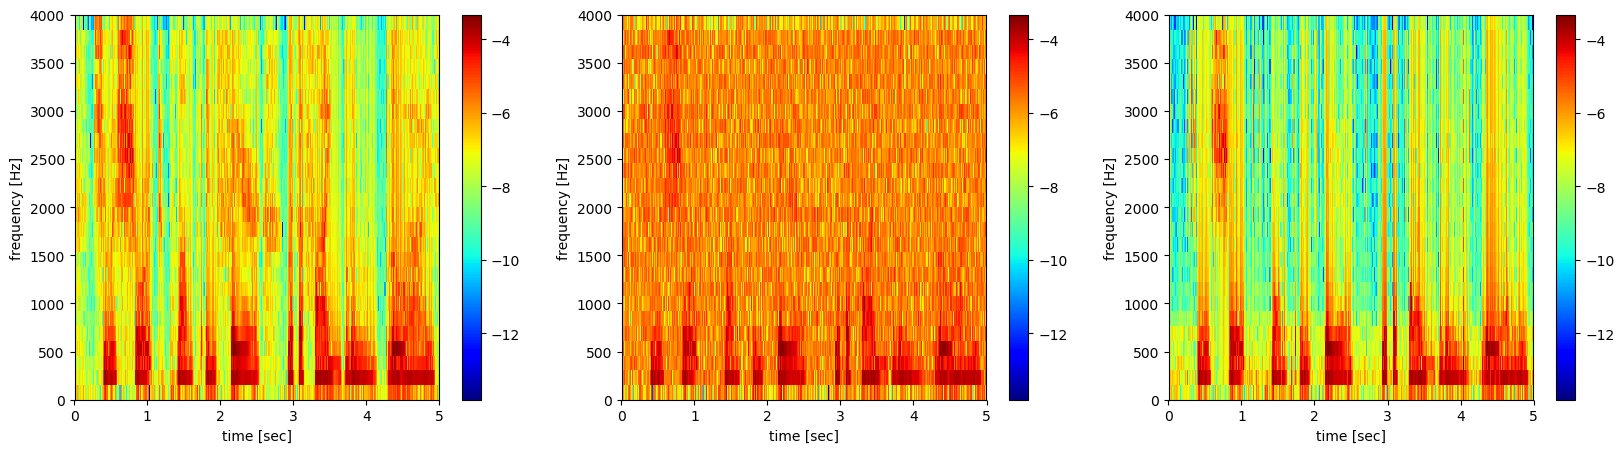

In [22]:
#plt.imshow(ξ_inferred',origin="lower", aspect="auto"), plt.colorbar()
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
cmp = plot_spectrogram(spectrogram(y_speech_true, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[1], colorbar=true)
plot_spectrogram(spectrogram(y_speech_n, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[2])
plot_spectrogram(spectrogram(y_enhanced, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[3])
#ax[1].get_images()[1].set_clim(-13, -3)
vrange = ax[1].get_images()[1].get_clim()
fig.colorbar(cmp, ax=ax[2])
ax[2].get_images()[1].set_clim(vrange)
fig.colorbar(cmp, ax=ax[3])
ax[3].get_images()[1].set_clim(vrange)
;

<source src="data:audio/wav;base64,UklGRjxxAgBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQBxAgALM0K8iDVHPRCz2jzCW8q618nAu1MnXD3PUY67YH2FPHpImTuNYtQ84gGxvAS+dzutUpa88lEzvLx99jsR5148Y34yPOWwSr04PiM99KY+PU/da7vWz1q8KQAEPUqZkD3JH3Y7SzibvL/4wzy7RdY8wlBJuoZRtL2aOTA8d+yCPJZ0uzwZVx69ByxjvFhMoz2Qi6C8TwJAOqcTSLzcgDI9kWPePKo+yrwafCq6Ik8sPO27+Ds9DEM8gOfnuxaJ7rvdcO48gTwMPCULljy+F3+8JxoaOyAVsjp5Lq48NLOpPKT1i7tm4HU8tzQFusyuLbvbE548rOvEPEVr+rsK3FU8l0glO0tcTrynFuu8b9JPPcBHljvay5w7HfFbvcjRaz2Pu6g8zefxOsAGjLw4xPM81EQRPXDC7rw9h9c8AO8SPfDGvbpN7Ry9ORSZPBZtSD1KSK48Oo8dvLMcFz1erEA9r/EXPBx31rtVZrU8nVAiPOOc8LtPoFK7vrGUPHy7qDxG1kM8GA1Ou7D0aj2cOg49bL+xO1udlzzNOBE9X+qqPI/qLLz4niY8RgllPFxAdrxI5ei6cZDvu4kXSTzJo+08DSvVu5bBmDxMyAo934ocPdiCKL0zaG67c6mPPFivybvuNQ483y19vHm9K7zeDk48kPAZPF1J7zxwutO7xAzMPAryhzvivay6MIDNPMF3hDwEaEE9dW+nvFz4R7uOcv27/R4RPXPi1rtI3Oy8PoE5vLsjHbwxgxA9l4lxu4OKPb08fhK6h7AEPS7dqzxmZv27a3gEvdv0gD26Iu48l7GcvGr/Tr0EW3888EpfPCaKSDqtLsC8L7aFPEk+6TwRVCw7vM2mvOogDryVzEY81w1kvAscnryd/4i8ivNBOxks6bzHL8i89lnlvLh857unv8K8QahZPCeWAr3HbOA4nsY1u/sg37wK/Uu8K77vumlUOTz0wjO9oRUkvO7GHrzr3IE8ot1/vKgGRrwAZLE8qjkKO64lsbs2pN68W7IFvOIRTrt6fDQ8j8U1uz1n6DwlMb+8Od/IvD5aH7x408s8R9kyvJvKWb1gVrg8yLYnPcsez7wgbF69YWGovGd9KD1wEP08NzOGvZYrmbyKAUs9pqVVPYXKtb3pE9S8ngx1PHVHfT0+t/C7YqMLvZYNBL1aSSY96cmCPCeMs7yybhy9pm4AO9ooBj0mpiK8LvY/vY+3lDuulac8YSfSvLd74rzaYeG8ytKvPH+kWTzbEgW8qR6uvEoDpLv6hNg88c0bPHogEL3BQyq82HB5vD2m8DuTjC2933U0uxbalLxvAMW6pcwdPWSByrugYQq89tWruxDWODzRP1k7lTepOkm1krxv9qy7eGFBvCXjlbxZsCO9hO+ZPK8dybxaBS68HdsJvDn2zDzQ0wu7eX29vKohwrwMIJy8AAiuPC8qmbvKJQ+91Gkova6s7zqAawK9EBZFvVBM4LzqSL08k+igvBjpaju9o8U7i9GKPHs3Zr3eSR27dFAWPZzUJ7zXRoS9CFkRvY3xgjzSt928fD2DvXAg3LzwGh+8Z064PKh55bwq8qq7g+KhvIT3TrpLliI8+PArvdNcszt/OoU6YhWIPDODib1I5rI8zcpDPfc9Kr3lKAO9APeMPJNVfj0lZhK954oAvZZgrbszP6w7ts4xvd5FsDuHYaC8BlQRPZy4Ab0Dl/i3u+g7O2wKBzzYLhs92gJ1vULl2rwrlmU8D+pUPVHrEL12UNC8NnP/PKSUmj39yyM89jUVvfxWMLtl2zo9PwYZvMPs+bvRTyw8++jePIHEczy0vTe9gpL7PAT+SD3aR168YLQXva2K57xJC209LirCvCreh7xvGrC86R6qPDf4srr9Ook8JrjzO5Ac1Dxq8yO8p9WUtx9DkjvL0MG8DDXYPIWB7Dyx7VU8p3tNvUVzOTzIAkE9LcreO6RdiL1Ou4U85N1aPcQueTt9fWe9UPU5vENQZT0BtVE9Wg+FOcPDzrxgq0E9UaVnPcIBe7yUyfW7BvhOu3FE9jtyfEc8vojfvDdFTjxYecY8JXh2vG4puTyZnc27jEFEPW1FxTs09C+81Q2gOtRrLDx6cxQ9c1WTvAzchzyghw09GOY2PLOArbymN807Pl0tPWY1ZrxTdwS9CTmQPLVfojtC8AW9sTg3vHbqRT1tH4M8dLe3u23mdDxhYak8etc6Pdk5xTxGsVU8ddZ1uxu4n7wa7Ry7zoD3OWW4y7sZW628ouTku0Utfjy5l7M7pItjvNTuOzyGRAQ8sY+LPLttazxR+nU8ZOSpPEoiNjzhy5o8S2UJPEgbjz2P9ky82eUqvHXnzbtds+U7sOuovKAvVLwqNIM83CLOPFjL7Du62A68X04bu5dArzzsoOQ8ZiUEvELmy7xTLtm80lJDPaYuVbz1VDS9b/wXvaX0jDhwXsg8LR8VvB3ynLvnQg294T7NPNFGjDvPa1q9a9XFvOqhSbwi1qE8j6fePCaOz7urEIe869koPDe60Dzj28c86U0+vGJXurzuLas8OQwOPenyDr3XuFG9qR/iO9TBdjsc4QI8hBPCPOHKiTvAVFo918SUO1gM5jswc8U8kO+jPDMvejze5dC8evkvPIb+ODwvloc7/jVsvTr0Ej3f7So9+V3mvJKIXb0wvvA8NqdHPYbIlrzMiFm94eAIPacx4zw8/AY92Qx5vBC5KTuztqE6BEWBPB6hl7zMVxu9pAODvNa4AzxjZua8jTpSvb3+G7yGV7s7a6iaPN5bH70S6yK8uq3UPICn/jzIw1S9ZOgTvH5MtrveAJM8fA0jvXSLI73+31e70IIOvO0Wpbyo8WW8SnyEPLR9mLw6KhI8ycCXPAmQ3zu9ES28vYt2Oo4gQbyo4jQ85DiqO2BYsLt/0M68JLGDu0383TzptZW82VuEOyv7LDvIwZk7i4OavMU9aTyeCvK8gLfZvODvozz8Mp48R550PHvVkL2PBQE9aMBMPMqjkrqQT3q8uIeUvJLmQzydvf08/nFOPJ1qJTztylO8IOPnO8WEVT1zQQs99KY1O0YliLySkVe8+/5CPWRjJTy46rC86bW+vFXF0DxEZh09Jlu6vLzn6LyvH1889l3sPGh5ejsXm3O8DoZdu4R3VjxFR3q8bJHXvEzHqrxTGCc9MAIlPPpt3rtapwm82HcDPW8t0zwnBW28m/qCvBkZfrzvsvw88xeQvCgqdrxsEa27Fb7bu/w0vrwtFky8rXjaOzpljLsUAHG84FhaOxcEmLuaD6W7pdKXvJAemjxs1fE63bhdvLD+47tC2N87svDCOyOejLz/eLy7OyIFuiLCY7zJKGc8/36uvHlXkjlZpr+6uJ0ivI34bLzaiYy62l68PIAMnrzb5C69W6KsPOJaIzyVs3M6fyv7vGLQH7zders7+venvI+uLb2IFa+8uVWVO0z5HLzCHxe8VesFvbWoEbs/vvs8mgt1vA+/Gb3I6BW8HZDwPAsVnTvOkvS8DR/LvNdOyzssoPG7Ak9XvMTpLry8NI68U3StPEWxb7tfw/s8AfWOvMTXATyrkPw6kivFvA+lRL2RsJQ88MpAPeX+MrtavUw81vsDvSjeizzBEda78ttJvNDct7z7w9g8WLLhPIOMwztSEUS8lys+vLwqPzpB1+i8Rk4DvcMnkTji57O8TT0EvYpr3LvHvCk6QD+RvJlNJb1phVe6HdxmvPzIlTsXap+8O+qrOsHtGTxNQ6A7F5Otuyj3ObxTp9Y8u7gfvEyzH73HRM+8jyypPJhPkrxMBEO8LViIu7YACz1Zem06m70xPDZsjbv8jZm7zhSkPM39oDsIHCo8PEMcvclm9jxM5UM4HLXzO5SY/rygk/U7DyWZPHnbhjyWL

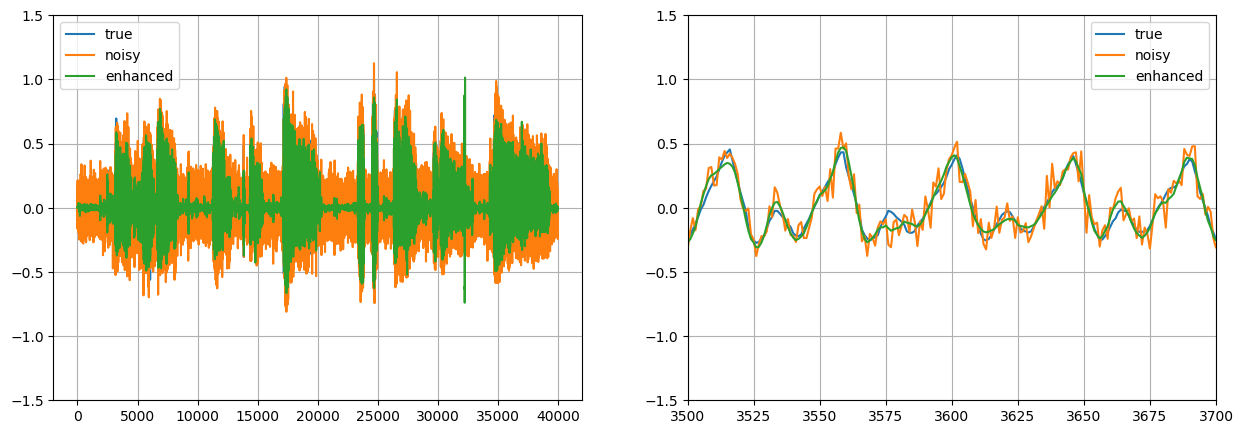

In [23]:
# plot signals
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech_true, label="true")
ax[1].plot(y_speech_n, label="noisy")
ax[1].plot(y_enhanced, label="enhanced")
ax[2].plot(y_speech_true, label="true")
ax[2].plot(y_speech_n, label="noisy")
ax[2].plot(y_enhanced, label="enhanced")
ax[1].grid(), ax[2].grid(), ax[2].set_xlim([3500, 3700]), ax[1].legend(), ax[2].legend()
ax[1].set_ylim(-1.5,1.5), ax[2].set_ylim(-1.5,1.5)
audioplayers(y_speech_true, y_speech_n, y_enhanced, fs=fs)

In [24]:
mean(abs2.(y_speech_true - y_speech_n)), mean(abs2.(y_speech_true - y_enhanced))

(0.009956168122870158, 0.0033176753113091833)

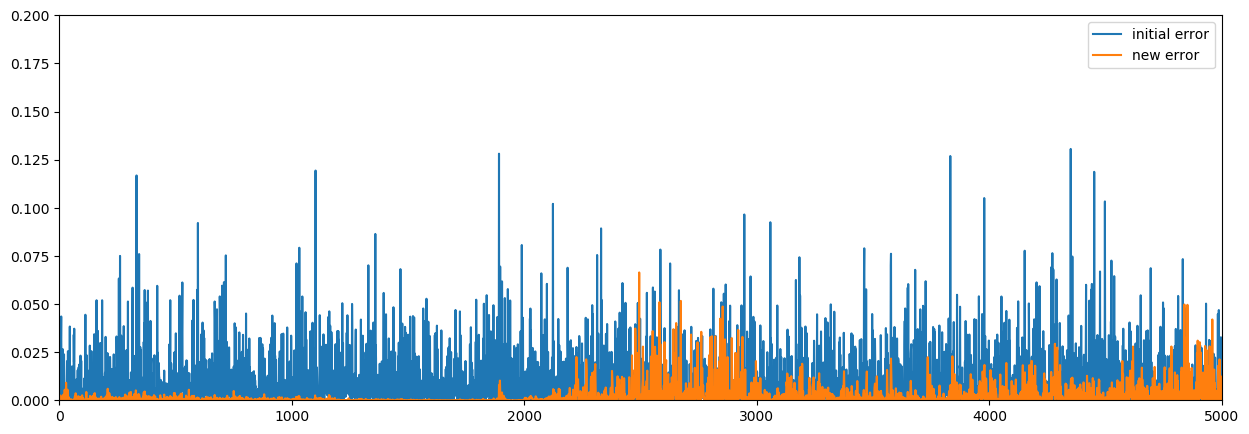

(0, 5000)

In [25]:
plt.figure(figsize=(15,5))
plt.plot(abs2.(y_speech_true-y_speech_n), label="initial error")
plt.plot(abs2.(y_speech_true-y_enhanced), label="new error")
plt.legend()
plt.ylim(0, 0.2)
plt.xlim(0,5000)

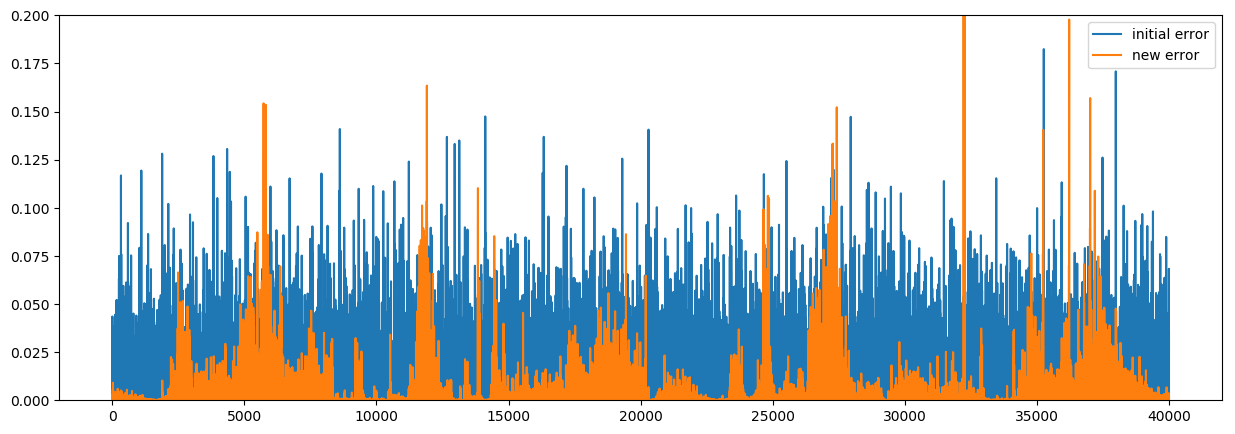

(0, 0.2)

In [26]:
plt.figure(figsize=(15,5))
plt.plot(abs2.(y_speech_true-y_speech_n), label="initial error")
plt.plot(abs2.(y_speech_true-y_enhanced), label="new error")
plt.legend()
plt.ylim(0, 0.2)